In [11]:
import monai
import shutil
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    Spacingd,
    RandWeightedCrop,
    RandRotate,
    RandFlip,
    Rand3DElasticd,
    Rand3DElastic,
    RandRotated,
    LoadImage,
    EnsureChannelFirstd,
    Orientationd,
    EnsureChannelFirst,
    ScaleIntensityd,
    RandFlip,
    ToTensor,
    SpatialPadd,
    ToTensord,
    ScaleIntensity,
    RandFlipd)
import nibabel
import shutil
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, PersistentDataset, SmartCacheDataset, ThreadDataLoader
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import nibabel
from glob import glob
from monai.networks.blocks import Convolution
from monai.networks.nets import Discriminator, Generator
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping
import numpy 
import torchvision.transforms as transforms
import random
from functools import reduce
from operator import mul
from torch.utils.data import DataLoader

from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

In [12]:
date="July21"#  put current date if training, test if just testing

if not os.path.exists(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}'):
    os.makedirs(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}')
    
if date != "test":
    shutil.copy('/home/fogunsan/scratch/degad/repo/MRI-DeGad/src/9a-train_degad_GAN_c3d_32.py', f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/')

In [13]:
fname_tr='/localscratch/tmp/training_samples_31.dat'
                        # Patch dimensions

patch_radius= numpy.array([15,15,15])
dims = 1+2*patch_radius 
dims = dims.astype('int')

k = 2                                 # Number of channels
bps = (4 * k * numpy.prod(dims))    # Bytes per sample
np_tr = os.path.getsize(fname_tr) // bps      # Number of samples

arr_shape_tr= (int(np_tr),dims[0],dims[1],dims[2], k)

arr_train = numpy.memmap(fname_tr,'float32','r+',shape=arr_shape_tr)

In [14]:
fname_va='/localscratch/tmp/validation_samples_31.dat'
                        # Patch dimensions

np_va = os.path.getsize(fname_va) // bps      # Number of samples

arr_shape_va= (int(np_va),dims[0],dims[1],dims[2], k)

arr_val= numpy.memmap(fname_va,'float32','r+',shape=arr_shape_va)

In [17]:
arr_train = numpy.swapaxes(arr_train,1,4)
arr_val = numpy.swapaxes(arr_val,1,4)
train_size=int(arr_train.shape[0]*1)
#train_size=int(arr_train.shape[0])

val_size=int(arr_val.shape[0]*1)
#val_size=int(arr_val.shape[0]) # reduced size to accelerate training
arr_train_image = arr_train[0:train_size,0,:,:,:].reshape(train_size,1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])
arr_train_label = arr_train[0:train_size,1,:,:,:].reshape(train_size,1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])

arr_val_image = arr_val[0:val_size,0,:,:,:].reshape(val_size,1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
arr_val_label = arr_val[0:val_size,1,:,:,:].reshape(val_size,1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])

In [18]:
arr_train_dict= [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(arr_train_image,arr_train_label)]
arr_val_dict= [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(arr_val_image,arr_val_label)]


In [19]:
train_transforms = Compose([SpatialPadd(keys = ("image","label"), spatial_size = (32,32,32)), Rand3DElasticd(keys = ("image","label"), sigma_range = (0.5,1), magnitude_range = (0.1, 0.4), prob=0.4, shear_range=(0.1, -0.05, 0.0, 0.0, 0.0, 0.0), scale_range=0.5, padding_mode= "zeros"),
          RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=1),RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=0),RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=2)])
val_transforms = Compose([SpatialPadd(keys = ("image","label"),spatial_size = (32,32,32))])

In [20]:
train_patches_dataset = CacheDataset(data=arr_train_dict ,transform = train_transforms, cache_rate =1.0, copy_cache=False, progress=True) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=arr_val_dict ,transform = val_transforms, cache_rate = 1.0, copy_cache=False,progress=True)

Loading dataset: 100%|██████████| 701/701 [00:01<00:00, 458.94it/s]


In [22]:
gen=UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024, 1024, 1024),
    strides=(2, 2, 2, 2, 1, 1, 1),
    dropout=0.2,
    norm='BATCH'
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
gen.apply(monai.networks.normal_init)
gen_model = gen.to(device)

In [23]:
class GANDiscriminator(nn.Module):
    def __init__(self, in_channels=2, kernel_size=3):
        super().__init__()
       
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size, stride=2, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size, stride=2, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size, stride=2, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU()
        )
        
        self.conv_out = nn.Conv3d(256, 1, kernel_size, stride=1, padding=0)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x
disc = GANDiscriminator()
disc.apply(monai.networks.normal_init)
disc_model = disc.to(device)

In [24]:
def GeneratorLoss(nongad_images,degad_images, fake_preds):
    """
    Loss function is the sum of the binary cross entropy between the error of the discriminator output btwn gad and degad (fake prediction) and the root mean square error betwn as nongad and degad images multiplies by scalar weight coefficient
    nongad_image= real nongad images from the sample
    degad_images= generated nongad images from the generator
    fake_preds: output of discriminator when fed fake data
    """
    
    coeff = 0.01
    
    BCE_loss= torch.nn.BCELoss() 
    real_target = torch.ones((fake_preds.shape[0], fake_preds.shape[1], fake_preds.shape[2], fake_preds.shape[3], fake_preds.shape[4])) #new_full returns a tensor filled with 1 with the same shape as the discrminator prediction 
    fake_preds = torch.sigmoid(fake_preds) # applying sigmmoid function to output of the discriminator to map probability between 0 and 1
    BCE_fake = BCE_loss(fake_preds.to(device), real_target.to(device)) # BCE loss btwn the output of discrim when fed fake data and 1 <- generator wants to minimize this
    L1_loss = torch.nn.L1Loss()
    loss = L1_loss(degad_images, nongad_images)  # producing RMSE between ground truth nongad and degad
    generator_loss = loss*coeff + BCE_fake
    return generator_loss

In [25]:
def DiscriminatorLoss(real_preds, fake_preds):
    """
    Loss function for the discriminator: The discriminator loss is calculated by taking the sum of the L2 error of the discriminator output btwn gad and nongad( real prediction ) and the L2 error of the output btwn gad and degad( fake predition)
    
    real_preds: output of discriminator when fed real data
    fake_preds: output of discriminator when fed fake data
    """
    
    real_target = torch.ones((real_preds.shape[0], real_preds.shape[1], real_preds.shape[2],real_preds.shape[3], real_preds.shape[4])) #new_full returns a tensor filled with 1 with the same shape as the discrminator prediction 
    
    fake_target = torch.zeros((fake_preds.shape[0], fake_preds.shape[1], fake_preds.shape[2], fake_preds.shape[3], fake_preds.shape[4])) #new_full returns a tensor filled with 0 w/ the same shape as the generator prediction
    BCE_loss =  torch.nn.BCELoss().to(device)  # creates a losss value for each batch, averaging the value across all elements
    # Apply sigmoid to discriminator outputs, to fit between 0 and 1
    real_preds = torch.sigmoid(real_preds).cuda()
    fake_preds = torch.sigmoid(fake_preds).cuda()
    
    BCE_fake = BCE_loss(fake_preds.cuda(), fake_target.cuda()) # BCE loss btwn the output of discrim when fed fake data and 0 <- generator wants to minimize this
    BCE_real = BCE_loss(real_preds.cuda(), real_target.cuda()) # BCE loss btwn the output of discrim when fed real data and 1 <- generator wants to minimize this
    
    return BCE_real + BCE_fake
   

In [28]:
learning_rate = 2e-4
betas = (0.5, 0.999)
batch_size = 64 # changed back to 64
gen_opt = torch.optim.Adam(gen_model.parameters(), lr = learning_rate, betas=betas)
disc_opt = torch.optim.Adam(disc_model.parameters(), lr = learning_rate, betas=betas)

epoch_loss_values = [0] # list of generator  loss calculated at the end of each epoch
disc_loss_values = [0] # list of discriminator loss values calculated at end of each epoch
disc_train_steps = 7 # number of times to loop thru discriminator for each batch

gen_training_steps = int(np_tr / batch_size) # number of training steps per epoch
disc_training_steps = disc_train_steps * gen_training_steps # number of validation steps per epoch

max_epochs = 250
start = time.time()

train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

for epoch in range(max_epochs):
    gen_model.train()
    disc_model.train()# setting models to training mode
    epoch_loss = 0 # initializing epoch loss for generator
    disc_epoch_loss = 0 # initializing  epoch loss for discriminator
    progress_bar(
            index = epoch +1,
            count = max_epochs, 
            desc = f"epoch {epoch + 1}, avg gen loss: {epoch_loss_values[-1]:.4f}, avg disc loss: {disc_loss_values[-1]:.4f}",
        )
    for i,train_batch in enumerate(train_loader):# iterating through dataloader
        
        gad_images =train_batch["image"].cuda()# initial gad image of batch
        nongad_images = train_batch["label"].cuda() # initial nongad image of batch that i plan on concatenating onto since bug with batch function in monai
        gen_opt.zero_grad()
        degad_images = gen_model(gad_images) # feeding CNN with gad images
        #disc_real_pred = disc_model(torch.cat([gad_images, nongad_images], dim=1))
        disc_fake_pred = disc_model(torch.cat([gad_images, degad_images], dim=1)) # getting disc losses when fed fake images
        
        gen_loss = GeneratorLoss(nongad_images, degad_images, disc_fake_pred) # getting generator losses
        gen_loss.backward()# computes gradient(derivative) of current tensor, automatically frees part of greaph that creates loss
        gen_opt.step() # updates parameters to minimize loss
        epoch_loss += gen_loss.item() # adding generator loss for this batch to total gen loss for this epoch
        for _ in range(disc_train_steps):
            gad_images = gad_images.clone().detach() # 
            nongad_images = nongad_images.clone().detach()#need to recall it for each iteration to avoid error message of backpropagation through a graph a second time after gradients have been freed
            degad_images = gen_model(gad_images) # feeding CNN with gad images
            disc_opt.zero_grad() # resetting gradient for discrminator to 0
            disc_real_pred = disc_model(torch.cat([gad_images, nongad_images], dim=1))
            disc_fake_pred = disc_model(torch.cat([gad_images, degad_images], dim=1)) # getting disc losses when fed fake images
            disc_loss = DiscriminatorLoss(disc_real_pred,disc_fake_pred)
            disc_loss.backward() #initializes back propagation to compute gradient of current tensors 
            disc_opt.step() # updates parameters to minimize loss
            disc_epoch_loss += disc_loss.item() # taking sum of disc loss for the number of steps for this batch
    epoch_loss = epoch_loss / gen_training_steps # epoch loss is the total loss by the end of that epoch divided by the number of steps
    epoch_loss_values.append(epoch_loss) #updates the loss value for that epoch
    disc_epoch_loss= disc_epoch_loss / disc_training_steps# average disc epoch loss is the total loss divided by the number of discriminator steps
    disc_loss_values.append(disc_epoch_loss) # avg disc loss is the total loss divided by the total disc steps in the epoch
end = time.time()
time = end - start



2/2 epoch 2, avg gen loss: 0.0065, avg disc loss: 0.0132 [==============================]


In [29]:
with open (f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/model_stats.txt', 'w') as file:  
    file.write(f'training time: {time} \n')  
    file.write(f'generator loss: {epoch_loss_values[-1]} discriminator loss: {disc_loss_values[-1]}')

In [30]:
################Saving trained generator and discriminator networks

torch.save(gen_model.state_dict(), f"/home/fogunsan/scratch/degad/derivatives/GAN/{date}/trained_generator.pt")
torch.save(disc_model.state_dict(), f"/home/fogunsan/scratch/degad/derivatives/GAN/{date}/trained_discriminator.pt")

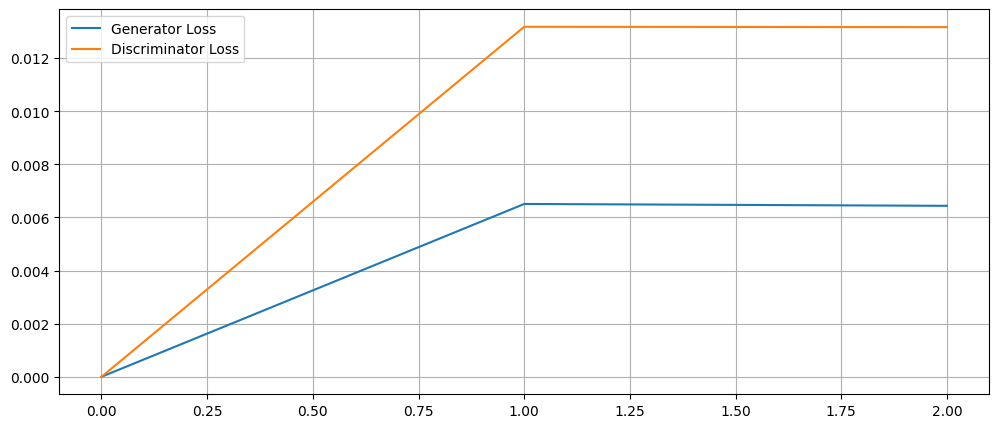

In [36]:
plt.figure(figsize=(12,5))
plt.plot(list(range(len(epoch_loss_values))), epoch_loss_values, label="Generator Loss")
plt.plot(list(range(len(disc_loss_values))), disc_loss_values , label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/lossfunction.png')


In [37]:
gen_model.load_state_dict(torch.load(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/trained_generator.pt'))
gen_model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(1

In [38]:
# running inference 
test_gad_t1= sorted(glob('/project/6050199/akhanf/cfmm-bids/data/Lau/degad/derivatives/passing_dataset/sub-P*/*rescaled_T1w.nii.gz'))[-1:]
# gad images who's corresponding nongad images underwent a rigid transform
test_nongad_t1= sorted(glob('/project/6050199/akhanf/cfmm-bids/data/Lau/degad/derivatives/passing_dataset/sub-P*/*nongad_normalized_fcm.nii.gz'))[-1:] # nongad images which underwent a rigid transform and underwent fcm normalization
test_files = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(test_gad_t1,test_nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled


inference_transforms = Compose( #loading full image
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"])])
        

infer_ds = Dataset(data=test_files, transform=inference_transforms) 
infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=True) #using pytorch's dataloader


In [40]:
degad_imgs = []
gad_infer_imgs = []
nongad_infer_imgs = []
for infer_imgs in infer_loader:
    gad_infer_imgs.append(infer_imgs["image"])
    nongad_infer_imgs.append(infer_imgs["label"])
    output_degad_img = sliding_window_inference(inputs = infer_imgs["image"].to('cpu'), roi_size = (32,32,32), sw_batch_size= 5, predictor = gen_model.to('cpu'), overlap = 0.25, mode = "gaussian", sw_device= 'cpu', device = 'cpu', progress = True )
    degad_imgs.append(output_degad_img)

100%|██████████| 264/264 [00:52<00:00,  5.04it/s]


In [43]:
for i in range(len(degad_imgs)): #looping thru number of output files
    degad_img =degad_imgs[i][0][0] # reshaping to exclude batch and channels (only one channel)
    gad_image= nibabel.load(test_files[i]["image"]) # getting original gad image back to compare to 
    gad_image_file = test_files[i]["image"]
    print(gad_image_file)
    sub = os.path.basename(gad_image_file).split("_")[0]
    degad_name = f'{sub}_acq-degad_T1w.nii.gz'
    degad_file = nibabel.Nifti1Image(degad_img.detach().numpy()*100, affine= gad_image.affine,header= gad_image.header) # with same header as inference gad 
    output_dir = f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/test'
    os.makedirs(f'{output_dir}/bids/{sub}/ses-pre/anat', exist_ok=True)# save in bids format
    output_path = f'{output_dir}/bids/{sub}/ses-pre/anat/{degad_name}'
    nibabel.save(degad_file,output_path) 

/project/6050199/akhanf/cfmm-bids/data/Lau/degad/derivatives/passing_dataset/sub-P063/sub-P063_acq-gad_rescaled_T1w.nii.gz


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


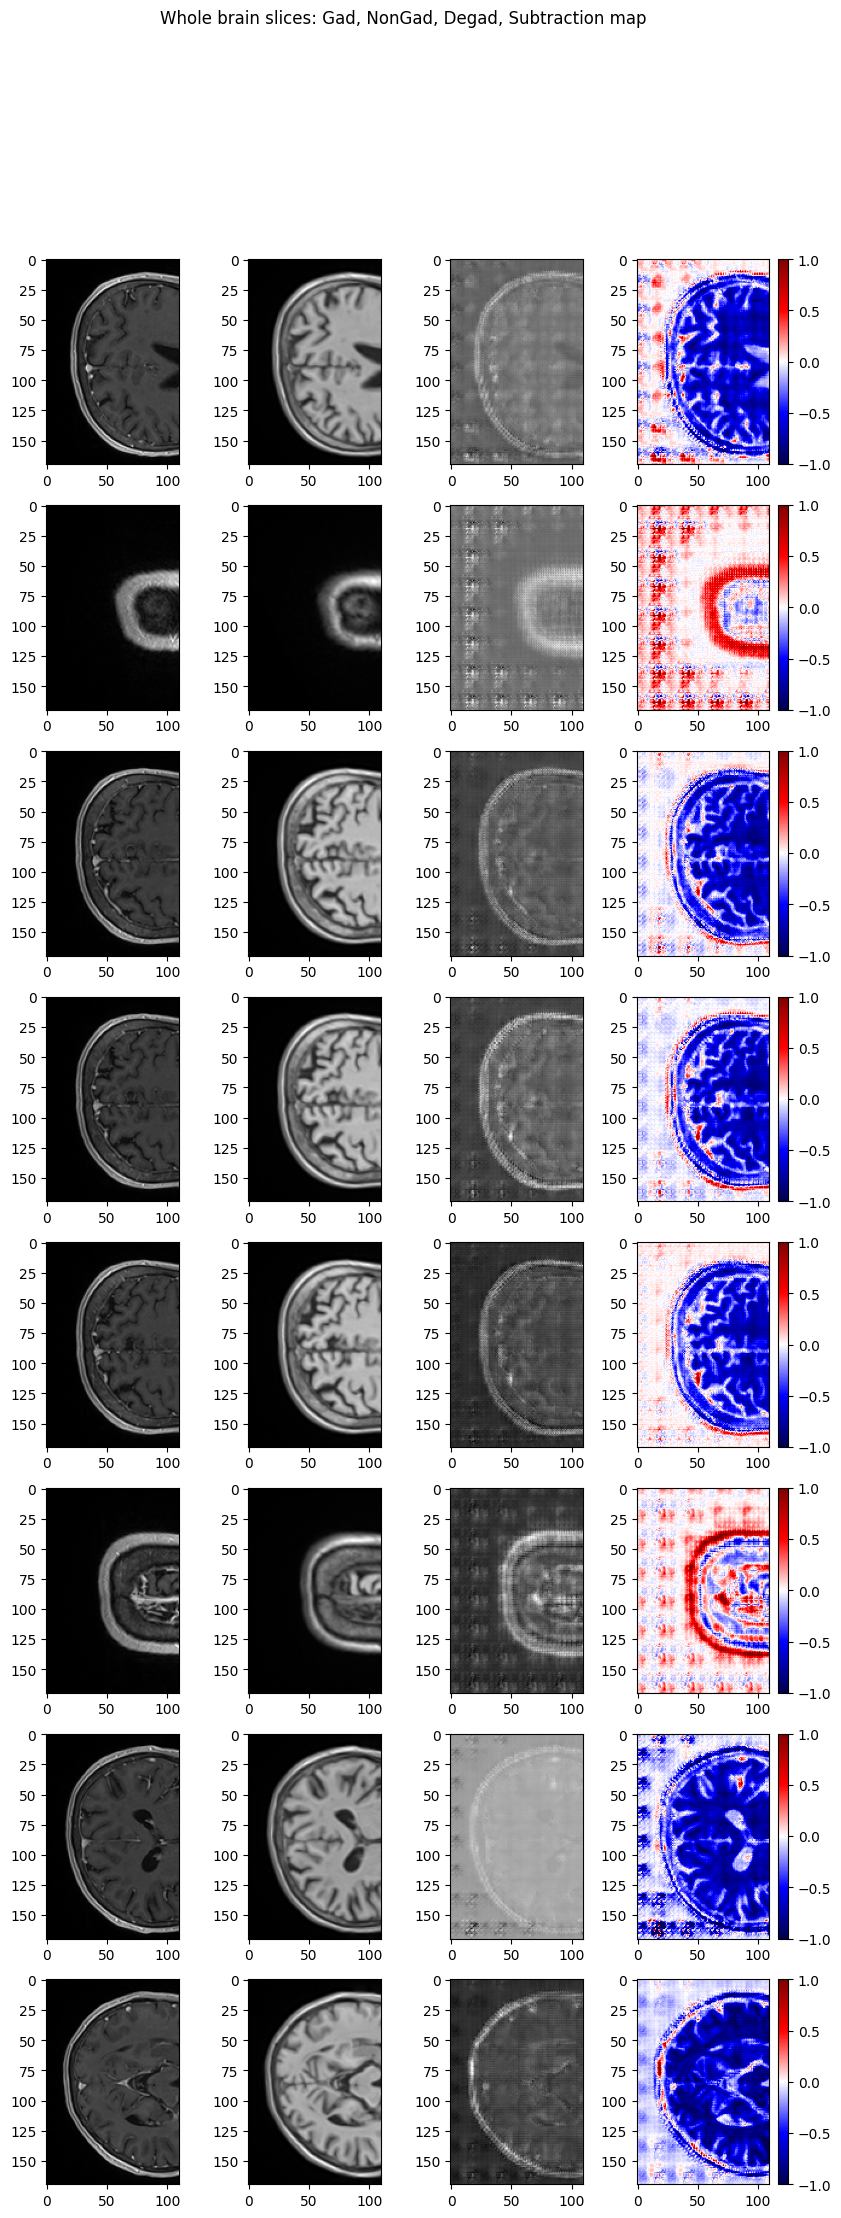

In [44]:
import random
## generating random whole brain slices
fig, axes = plt.subplots(8, 3,figsize=(10,25))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad, Subtraction map')

for i in range (1,33,4):
    plt.subplot(8, 4, i)
    x = random.randint(80, 190)
    plt.imshow(gad_infer_imgs[0][0, 0,40:210 ,40:150, x].cpu().data.numpy(), cmap ="gray")
    
    plt.subplot(8, 4, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, 40:210 , 40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 4, i+2)
    plt.imshow(degad_imgs[0][0, 0, 40:210,40:150, x].cpu().data.numpy(), "gray")

    plt.subplot(8, 4, i+3)
    noise_vector = degad_imgs[0][0,0,:,:,:] - nongad_infer_imgs[0][0,0,:,:,:] 
    #pos values are where model overestimated intensities and neg values are where the model underestimated
    plt.imshow(noise_vector[40:210,40:150, x].cpu().data.numpy(), "seismic",vmin=-1,vmax=1)
    plt.colorbar()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/test/figure_whole_brain.png')

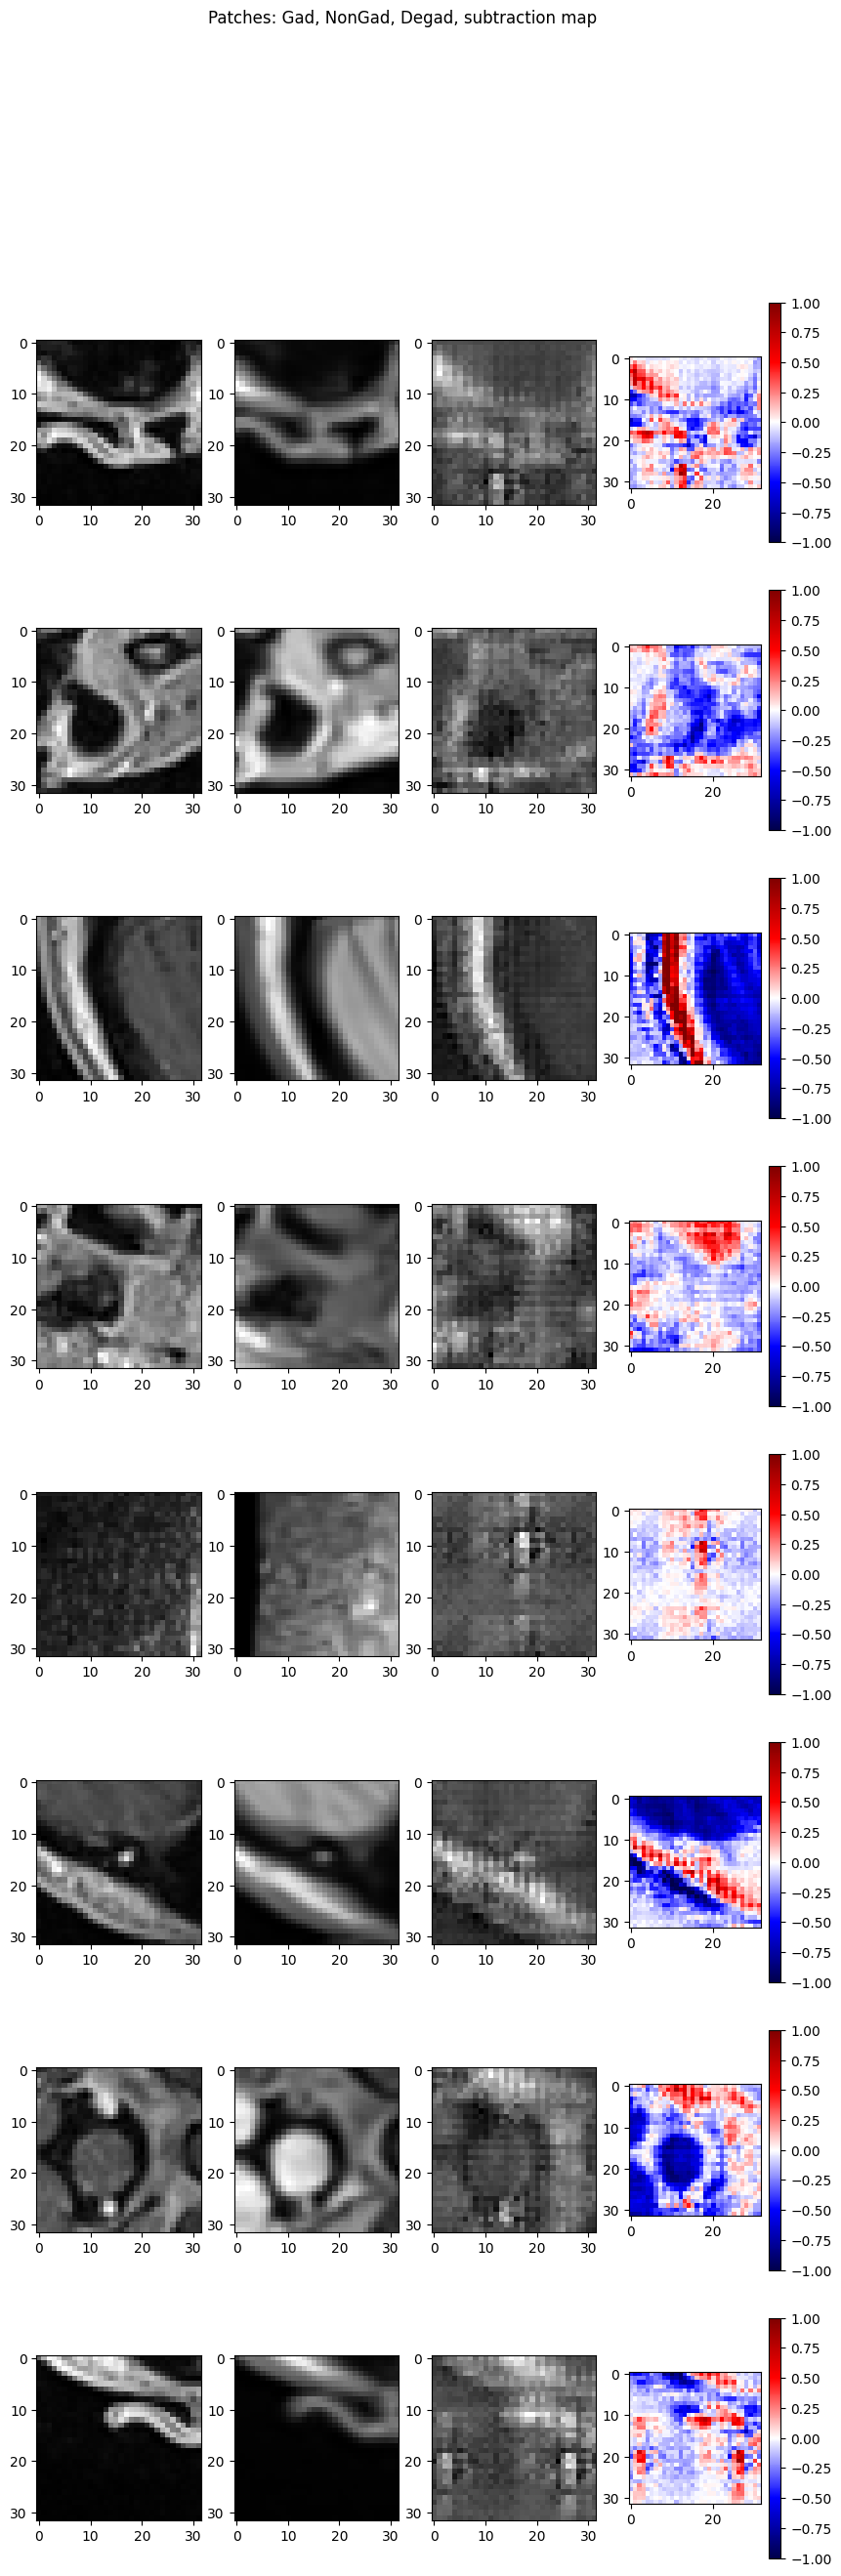

In [53]:
#generating random 32x32 slices
fig, axes = plt.subplots(8, 4,figsize=(10,30))
plt.suptitle('Patches: Gad, NonGad, Degad, subtraction map')

for i in range (1,33,4):
    
    x = random.randint(40, 190)
    y = random.randint(40, 190)
    z = random.randint(40, 190)
    plt.subplot(8, 4, i)
    plt.imshow(gad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), cmap ="gray")
    plt.subplot(8, 4, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, x:x+32,y:y+32 ,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 4, i+2)
    plt.imshow(degad_imgs[0][0, 0, x:x+32,y:y+32,50].cpu().data.numpy(), "gray")
   
    plt.subplot(8, 4, i+3)
    noise_vector = degad_imgs[0][0,0,:,:,:] - nongad_infer_imgs[0][0,0,:,:,:] 
    #pos values are where model overestimated intensities and neg values are where the model underestimated
    plt.imshow(noise_vector[x:x+32,y:y+32,50].cpu().data.numpy(), "seismic",vmin=-1,vmax=1)
    plt.colorbar()

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/GAN/{date}/test/figure_32_patches.png')  